In [1]:
from bs4 import BeautifulSoup as bs
from bs4 import Tag, NavigableString
import re
import requests as r
import pandas as pd
import numpy as np
import datetime
import csv
import os
import sys
from selenium import webdriver
import censusdata as cd
import geopy
import seaborn as sns

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.DataFrame(cd.search('acs1', 2018, 'concept', 'sex by age'))
df[df[0]=='B01001_001E']

,0,1,2
279,B01001_001E,SEX BY AGE,Estimate!!Total


In [3]:
blk_males = ['B01001B_003E',
'B01001B_004E',
'B01001B_005E',
'B01001B_006E',
'B01001B_007E',
'B01001B_008E',
'B01001B_009E',
'B01001B_010E',
'B01001B_011E',
'B01001B_012E',
'B01001B_013E',
'B01001B_014E',
'B01001B_015E',
'B01001B_016E']

In [4]:
df = df[(df[1].isin(['SEX BY AGE (SOME OTHER RACE ALONE)',
'SEX BY AGE (ASIAN ALONE)',
'SEX BY AGE (TWO OR MORE RACES)',
'SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE)',
'SEX BY AGE (WHITE ALONE)',
'SEX BY AGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)',
'SEX BY AGE (HISPANIC OR LATINO)',
'SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)']))&(df[0].str.startswith('C'))]

In [5]:
df[2].values

array(['Estimate!!Total', 'Estimate!!Total!!Male',
       'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Estimate!!Total!!Female!!Under 18 years',
       'Estimate!!Total!!Female!!18 to 64 years',
       'Estimate!!Total!!Female!!65 years and over', 'Estimate!!Total',
       'Estimate!!Total!!Male', 'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Estimate!!Total!!Female!!Under 18 years',
       'Estimate!!Total!!Female!!18 to 64 years',
       'Estimate!!Total!!Female!!65 years and over', 'Estimate!!Total',
       'Estimate!!Total!!Male', 'Estimate!!Total!!Male!!Under 18 years',
       'Estimate!!Total!!Male!!18 to 64 years',
       'Estimate!!Total!!Male!!65 years and over',
       'Estimate!!Total!!Female',
       'Esti

In [6]:
cd.geographies(cd.censusgeo([('state','11'),('public use microdata area','*')]),'acs1',2018)

{'District of Columbia (Central) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00105'))),
 'District of Columbia (East) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00104'))),
 'District of Columbia (North) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00102'))),
 'District of Columbia (Northeast) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00103'))),
 'District of Columbia (West) PUMA, District of Columbia': censusgeo((('state', '11'), ('public use microdata area', '00101')))}

In [7]:
df.head()

,0,1,2
3814,C01001A_001E,SEX BY AGE (WHITE ALONE),Estimate!!Total
3815,C01001A_002E,SEX BY AGE (WHITE ALONE),Estimate!!Total!!Male
3816,C01001A_003E,SEX BY AGE (WHITE ALONE),Estimate!!Total!!Male!!Under 18 years
3817,C01001A_004E,SEX BY AGE (WHITE ALONE),Estimate!!Total!!Male!!18 to 64 years
3818,C01001A_005E,SEX BY AGE (WHITE ALONE),Estimate!!Total!!Male!!65 years and over


In [8]:
census = cd.download('acs1', 2018,
                            cd.censusgeo([('state','11'),('public use microdata area','*')]),['B01001_001E']+list(df[0].values))
census

,B01001_001E,C01001A_001E,C01001A_002E,C01001A_003E,C01001A_004E,C01001A_005E,C01001A_006E,C01001A_007E,C01001A_008E,C01001A_009E,...,C01001G_009E,C01001I_001E,C01001I_002E,C01001I_003E,C01001I_004E,C01001I_005E,C01001I_006E,C01001I_007E,C01001I_008E,C01001I_009E
"District of Columbia (West) PUMA, District of Columbia: Summary level: 795, state:11> public use microdata area:00101",112727,88593,42591,7691,27195,7705,46002,7299,29004,9699,...,398,16048,7468,2576,4608,284,8580,1240,6572,768
"District of Columbia (North) PUMA, District of Columbia: Summary level: 795, state:11> public use microdata area:00102",135705,45736,23047,3205,18318,1524,22689,2784,17879,2026,...,287,30614,15419,5156,9836,427,15195,4194,9848,1153
"District of Columbia (Central) PUMA, District of Columbia: Summary level: 795, state:11> public use microdata area:00105",160725,101795,52322,2933,46375,3014,49473,2053,43531,3889,...,149,16350,9526,723,8139,664,6824,911,5205,708
"District of Columbia (Northeast) PUMA, District of Columbia: Summary level: 795, state:11> public use microdata area:00103",126312,54955,28012,5269,20562,2181,26943,4896,20508,1539,...,190,11724,6426,2339,4087,0,5298,2464,2755,79
"District of Columbia (East) PUMA, District of Columbia: Summary level: 795, state:11> public use microdata area:00104",166986,5668,3410,689,2357,364,2258,290,1545,423,...,73,4513,2301,1116,775,410,2212,1150,919,143


In [9]:
cols = ['SEX BY AGEEstimate!!Total']+ list(df[1].values + df[2].values)
census.columns = cols
census = census.reset_index()
census['index'] = census['index'].astype(str)
census['puma'] = np.where(census['index'].str.contains('(East)'),1,0)


C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [10]:
census = census[cols+['puma']].groupby(['puma']).sum().reset_index()

In [11]:
def check_save(file_path):
    path = ('data/{}'.format(file_path))
    if os.path.exists(path):
        os.remove(path)
    else:
        print("{} does not exist".format(file_path))
    

def write_out(file_path, url):
    path = ('data/{}'.format(file_path))
    print(file_path)
    with open(path, mode='w', newline='') as file:
        file_writer = csv.writer(file, delimiter=',')
        print(url)
        with r.get(url, verify=False, stream=True) as res:
            lines = (line.decode('utf-8',errors='ignore').replace('\0','') for line in res.iter_lines())
            for row in csv.reader(lines):
                print(row)
                file_writer.writerow(row)

                
                
def create_stuff(file_path,url):
    check_save(file_path)
    write_out(file_path,url)
    
def stack_csvs(my_url):
    with open(path, mode='w', newline='') as file:
        file_writer = csv.writer(file, delimiter=',')
        print(url)
        with r.get(url, verify=False, stream=True) as res:
            lines = (line.decode('utf-8',errors='ignore').replace('\0','') for line in res.iter_lines())
            for row in csv.reader(lines):
                print(row)
                file_writer.writerow(row)

In [13]:
#Downloads the .csv file of all mobility data from the google mobility site
#goog_files = os.getcwd()+'/data'


output = open('traffic_stops.csv', 'wb')
lst = []
        
my_url = ['https://mpdc.dc.gov/node/1429041','https://mpdc.dc.gov/node/1464816']
for url in my_url:
    html = r.get(url)
    soup = bs(html.content,'lxml')
    current_link = ''
    for l in soup.find_all('a'):
        current_link = l.get('href')
        if current_link != None:
            #print(current_link)
            if current_link.find('csv')> 0:
                xlsx_file = r.get(current_link)
                lst.extend(xlsx_file)
                
            '''        myfile = r.get(current_link)
                open('{}/{}'.format(goog_files, current_link.rsplit('/', 1)[1].rsplit('.csv',1)[0] + '.csv') ,'wb').write(myfile.content)
                break'''
output.write(xlsx_file.content)
output.close()

In [14]:
df = pd.read_csv('traffic_stops.csv',encoding = "ISO-8859-1")

C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df.shape
df.drop_duplicates(inplace=True)

In [16]:
df['zip_code'] = df['stop_location_block'].str.extract('([0-9][0-9][0-9][0-9][0-9])')

In [17]:
print(df.shape)


(20842, 53)


In [18]:
df['puma'] = np.where((df['stop_district']=='7D')|(df['stop_district']=='6D'),1,0)

In [19]:
df['age'] = np.where(df['age']=='Juvenile',17,df['age'])
df['age'] = pd.to_numeric(df['age'],errors='coerce')

In [20]:
df[(df['age']>=18)|(df['age']<=64)]

,observation,ccn_anonymized,stop_type,stop_date,stop_time,stop_location_block,stop_district,stop_duration_minutes,stop_reason_nonticket,stop_reason_harbor,...,ticket_count,warning_count,void_count,arrest_charges,gender,race_ethnicity,age,arrest_date,zip_code,puma
0,42001,NaN,Ticket Only,12/12/2019,23:47,400 BLOCK OF H ST NW,1D,10.0,NaN,NaN,...,2.0,0.0,0.0,NaN,Male,Black,29.0,NaN,NaN,0
1,42002,NaN,Ticket Only,12/21/2019,11:45,800 BLOCK OF BARNABY SE,7D,15.0,NaN,NaN,...,2.0,0.0,0.0,NaN,Female,Black,29.0,NaN,NaN,1
2,42003,NaN,Ticket Only,12/21/2019,11:45,800 BLOCK OF BARNABY RD SE,7D,15.0,NaN,NaN,...,1.0,0.0,0.0,NaN,Female,Black,29.0,NaN,NaN,1
3,42004,0x86804F7D9B77CAE97608A6781A6E3F942C65EC0B7698...,Non-ticket Stop,8/2/2019,0:15,"1100 BLOCK OF 19TH STREET NW WASHINGTON, DC 20...",2D,60.0,Call for service,NaN,...,NaN,NaN,NaN,Robbery,Male,Black,28.0,8/2/2019,20036,0
4,42005,NaN,Ticket Only,8/3/2019,17:44,GEORGIA AVE NW,4D,25.0,NaN,NaN,...,1.0,0.0,0.0,NaN,Male,Black,28.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20718,62719,0x8A82E2291992D05CE515ECAB2FB648626F3A7003D213...,Non-ticket Stop,11/13/2019,1:40,"1300 BLOCK OF CONGRESS STREET SE WASHINGTON, D...",7D,30.0,Call for service,NaN,...,NaN,NaN,NaN,NaN,Female,Black,17.0,NaN,20032,1
20719,62720,0xEC8EF871B61E4066E7523A9F809C43947463E9DA81B5...,Non-ticket Stop,11/6/2019,18:59,"900 BLOCK OF 4TH STREET SW WASHINGTON, DC 2002...",1D,9.0,Information obtained from witnesses or informa...,NaN,...,NaN,NaN,NaN,NaN,Male,Black,17.0,NaN,20024,0
20720,62721,0x63D403727F77D5DCE7CF09D68DCBD89F5FAC180EB3AE...,Non-ticket Stop,10/17/2019,22:14,3900 BLOCK OF MARTIN LUTHER KING JR AVENUE SW ...,7D,8.0,Call for service,NaN,...,NaN,NaN,NaN,NaN,Male,Black,17.0,NaN,20032,1
20721,62722,0xFCDC810657DE9513034A932A20C8102ECF521436C34C...,Non-ticket Stop,12/30/2019,16:04,1700 BLOCK OF INDEPENDENCE AVENUE SE WASHINGTO...,1D,100.0,Warrant/court order,NaN,...,NaN,NaN,NaN,NaN,Female,Black,17.0,NaN,20003,0


In [21]:
conditions =[
    df['age']<=17,
 (df['age']>=18)|(df['age']<=64),
    df['age']>64
]
df['age_range'] = np.select(conditions,['<18','18-64','>64'],default='')
df.head()

,observation,ccn_anonymized,stop_type,stop_date,stop_time,stop_location_block,stop_district,stop_duration_minutes,stop_reason_nonticket,stop_reason_harbor,...,warning_count,void_count,arrest_charges,gender,race_ethnicity,age,arrest_date,zip_code,puma,age_range
0,42001,NaN,Ticket Only,12/12/2019,23:47,400 BLOCK OF H ST NW,1D,10.0,NaN,NaN,...,0.0,0.0,NaN,Male,Black,29.0,NaN,NaN,0,18-64
1,42002,NaN,Ticket Only,12/21/2019,11:45,800 BLOCK OF BARNABY SE,7D,15.0,NaN,NaN,...,0.0,0.0,NaN,Female,Black,29.0,NaN,NaN,1,18-64
2,42003,NaN,Ticket Only,12/21/2019,11:45,800 BLOCK OF BARNABY RD SE,7D,15.0,NaN,NaN,...,0.0,0.0,NaN,Female,Black,29.0,NaN,NaN,1,18-64
3,42004,0x86804F7D9B77CAE97608A6781A6E3F942C65EC0B7698...,Non-ticket Stop,8/2/2019,0:15,"1100 BLOCK OF 19TH STREET NW WASHINGTON, DC 20...",2D,60.0,Call for service,NaN,...,NaN,NaN,Robbery,Male,Black,28.0,8/2/2019,20036,0,18-64
4,42005,NaN,Ticket Only,8/3/2019,17:44,GEORGIA AVE NW,4D,25.0,NaN,NaN,...,0.0,0.0,NaN,Male,Black,28.0,NaN,NaN,0,18-64


In [22]:
data = df.groupby(['puma','gender','race_ethnicity'])['age'].agg(['mean','count']).reset_index()
data = data[(data['gender']=='Female')|(data['gender']=='Male')]
data_age = df.groupby(['puma','gender','race_ethnicity','age_range'])['age'].agg(['count']).reset_index()
data_age = data_age[((data_age['gender']=='Female')|(data_age['gender']=='Male'))&(data_age['age_range']!='')]

In [23]:
data.head()

,puma,gender,race_ethnicity,mean,count
0,0,Female,Asian,24.02,87
1,0,Female,Black,23.23,2613
2,0,Female,Hispanic,23.03,291
3,0,Female,Multiple,26.00,8
4,0,Female,Other,19.50,2


In [24]:
data_age.head()

,puma,gender,race_ethnicity,age_range,count
0,0,Female,Asian,18-64,81
1,0,Female,Asian,<18,6
3,0,Female,Black,18-64,2302
4,0,Female,Black,<18,311
6,0,Female,Hispanic,18-64,268


In [25]:
census_mlt = census.melt(id_vars=['puma'])

In [26]:
census_mlt['variable'].values

array(['SEX BY AGEEstimate!!Total', 'SEX BY AGEEstimate!!Total',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!Under 18 years',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!Under 18 years',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!18 to 64 years',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!18 to 64 years',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!65 years and over',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male!!65 years and over',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Female',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Female',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Female!!Under 18 years',
       'SEX BY AGE (WHITE ALONE)Estimate!!Total!!Female!!Under 18 years',
       'SEX BY AGE (W

In [27]:
census_mlt['gender'] = np.where(census_mlt['variable'].str.contains('Male'),'Male','')
census_mlt['gender'] = np.where(census_mlt['variable'].str.contains('Female'),'Female',census_mlt['gender'])


In [28]:
def categorize(dic, column):
    census_mlt[column] = '' 
    for x in dic.keys():
         census_mlt[column] = np.where(census_mlt['variable'].str.contains(x),dic[x],census_mlt[column])
    return census_mlt[column]
    

In [29]:
census_mlt.head()

,puma,variable,value,gender
0,0,SEX BY AGEEstimate!!Total,535469.0,
1,1,SEX BY AGEEstimate!!Total,166986.0,
2,0,SEX BY AGE (WHITE ALONE)Estimate!!Total,291079.0,
3,1,SEX BY AGE (WHITE ALONE)Estimate!!Total,5668.0,
4,0,SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male,145972.0,Male


In [30]:
conditions = {
    '18 to 64 years':'18-64',
    'Under 18 years':'<18',
    '65 years and over':'>64'
    }
census_mlt['metric'] = categorize(conditions,'metric')    

In [31]:
conditions = {
    'SEX BY AGEE':'total',
'(WHITE ALONE)':'White',
'(BLACK OR AFRICAN AMERICAN ALONE)':'Black',
'(ASIAN ALONE)':'Asian',
'(SOME OTHER RACE ALONE)':'Other',
'(TWO OR MORE RACES)':'Multiple',
'(HISPANIC OR LATINO)':'Hispanic',
    }
census_mlt['race_ethnicity'] = categorize(conditions,'race_ethnicity')    

C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [32]:
census_mlt.head()

,puma,variable,value,gender,metric,race_ethnicity
0,0,SEX BY AGEEstimate!!Total,535469.0,,,total
1,1,SEX BY AGEEstimate!!Total,166986.0,,,total
2,0,SEX BY AGE (WHITE ALONE)Estimate!!Total,291079.0,,,White
3,1,SEX BY AGE (WHITE ALONE)Estimate!!Total,5668.0,,,White
4,0,SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male,145972.0,Male,,White


In [33]:
census_mlt = census_mlt.replace({'':'total'})
census_mlt

,puma,variable,value,gender,metric,race_ethnicity
0,0,SEX BY AGEEstimate!!Total,535469.0,total,total,total
1,1,SEX BY AGEEstimate!!Total,166986.0,total,total,total
2,0,SEX BY AGE (WHITE ALONE)Estimate!!Total,291079.0,total,total,White
3,1,SEX BY AGE (WHITE ALONE)Estimate!!Total,5668.0,total,total,White
4,0,SEX BY AGE (WHITE ALONE)Estimate!!Total!!Male,145972.0,Male,total,White
...,...,...,...,...,...,...
105,1,SEX BY AGE (HISPANIC OR LATINO)Estimate!!Total...,1150.0,Female,<18,Hispanic
106,0,SEX BY AGE (HISPANIC OR LATINO)Estimate!!Total...,24380.0,Female,18-64,Hispanic
107,1,SEX BY AGE (HISPANIC OR LATINO)Estimate!!Total...,919.0,Female,18-64,Hispanic
108,0,SEX BY AGE (HISPANIC OR LATINO)Estimate!!Total...,2708.0,Female,>64,Hispanic


In [34]:
census_mlt_race = census_mlt[(census_mlt['gender']=='total')&(census_mlt['metric']=='total')&(census_mlt['race_ethnicity']!='total')].copy()
census_mlt_gen = census_mlt[(census_mlt['gender']!='total')&(census_mlt['metric']=='total')&(census_mlt['race_ethnicity']!='total')].copy()
census_mlt_gen_age = census_mlt[(census_mlt['metric']!='total')].copy()

In [35]:
print(census_mlt.iloc[0:2])
print(census_mlt_race.groupby(['puma'])['value'].sum())
print(census_mlt_gen.groupby(['puma'])['value'].sum())
print(census_mlt_gen_age
      .groupby(['puma'])['value'].sum())

   puma                   variable     value gender metric race_ethnicity
0     0  SEX BY AGEEstimate!!Total  535469.0  total  total          total
1     1  SEX BY AGEEstimate!!Total  166986.0  total  total          total
puma
0    592541.0
1    168431.0
Name: value, dtype: float64
puma
0    592541.0
1    168431.0
Name: value, dtype: float64
puma
0    592541.0
1    168431.0
Name: value, dtype: float64


In [36]:
data.head()

,puma,gender,race_ethnicity,mean,count
0,0,Female,Asian,24.02,87
1,0,Female,Black,23.23,2613
2,0,Female,Hispanic,23.03,291
3,0,Female,Multiple,26.00,8
4,0,Female,Other,19.50,2


In [37]:
census_mlt_gen['pct'] = np.round((census_mlt_gen['value'] / census_mlt_gen['value'].sum())*100,2)
census_mlt_gen['var'] = 'population'
data['pct'] = np.round((data['count'] / data['count'].sum())*100,2)
data['var'] = 'traffic stops'
grp = pd.concat([data,census_mlt_gen],axis=0)

grp.head()

,puma,gender,race_ethnicity,mean,count,pct,var,variable,value,metric
0,0,Female,Asian,24.02,87.0,0.42,traffic stops,NaN,NaN,NaN
1,0,Female,Black,23.23,2613.0,12.66,traffic stops,NaN,NaN,NaN
2,0,Female,Hispanic,23.03,291.0,1.41,traffic stops,NaN,NaN,NaN
3,0,Female,Multiple,26.00,8.0,0.04,traffic stops,NaN,NaN,NaN
4,0,Female,Other,19.50,2.0,0.01,traffic stops,NaN,NaN,NaN


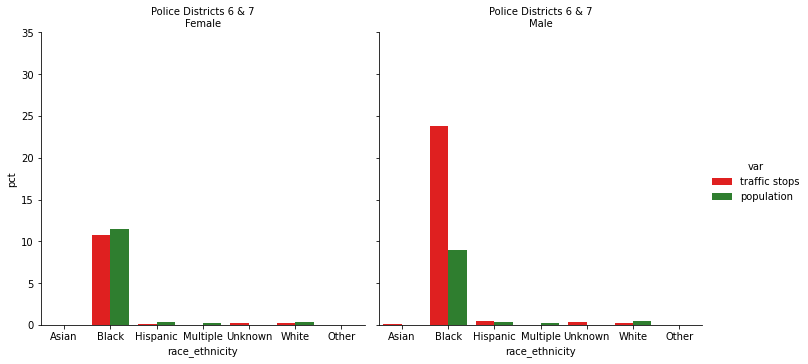

In [39]:
g = sns.catplot(x='race_ethnicity',y='pct',hue='var',col='gender',data=grp[grp['puma']==1],kind='bar',palette=sns.color_palette(['red', 'forestgreen']))
g.set_titles('Police Districts 6 & 7\n{col_name}')
g.set(ylim=(0, 35))

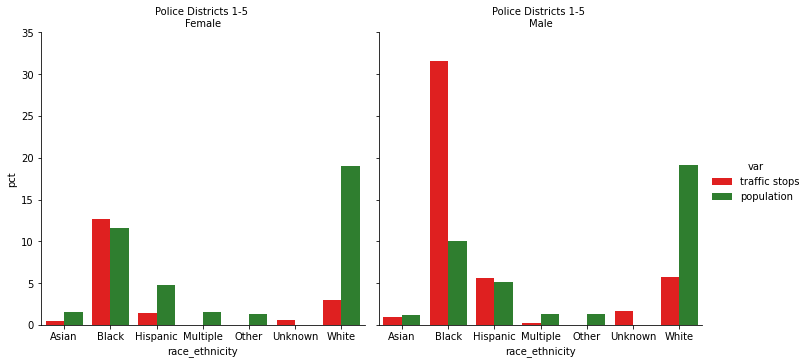

In [40]:
g= sns.catplot(x='race_ethnicity',y='pct',hue='var',col='gender',data=grp[grp['puma']==0],kind='bar',palette=sns.color_palette(['red', 'forestgreen']))
g.set_titles('Police Districts 1-5 \n{col_name}')
g.set(ylim=(0, 35))

# Reasons for Stops

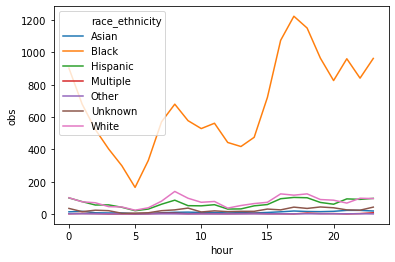

In [69]:
df['obs']= 1
df['hour'] = df['stop_time'].str.extract('(^[0-9]*[^\(:]+)')
df['hour'] = df['hour'].astype(float)
sns.lineplot(x='hour',y='obs',hue='race_ethnicity',data=df.groupby(['hour','race_ethnicity'])['obs'].sum().reset_index())

In [86]:
df['stop_reason'] = np.where(df['stop_reason_nonticket'].notnull(),df['stop_reason_nonticket'],df['stop_reason_harbor'])
df['stop_reason'] = np.where(df['stop_reason'].isnull(),df['stop_reason_ticket'],df['stop_reason'])
df_reasons = pd.concat([df,df['stop_reason'].str.split(';',expand=True)],axis=1)
df_reasons = df_reasons[['puma','observation','race_ethnicity','gender','age',0,1,2,3,4,5,6,7]].melt(id_vars=['observation','race_ethnicity','gender','age','puma'])
df_reasons.value = df_reasons.value.str.strip()
df_reasons.head()

,observation,race_ethnicity,gender,age,puma,variable,value
0,42001,Black,Male,29.0,0,0,Observed equipment violation
1,42002,Black,Female,29.0,1,0,Response to Crash
2,42003,Black,Female,29.0,1,0,Response to Crash
3,42004,Black,Male,28.0,0,0,Call for service
4,42005,Black,Male,28.0,0,0,Observed moving violation


In [87]:
grp = df_reasons.groupby(['puma','race_ethnicity','gender','value'])['age'].agg(['count','mean']).reset_index()
grp['pct'] = np.round((grp['count'] / grp['count'].sum())*100,2)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

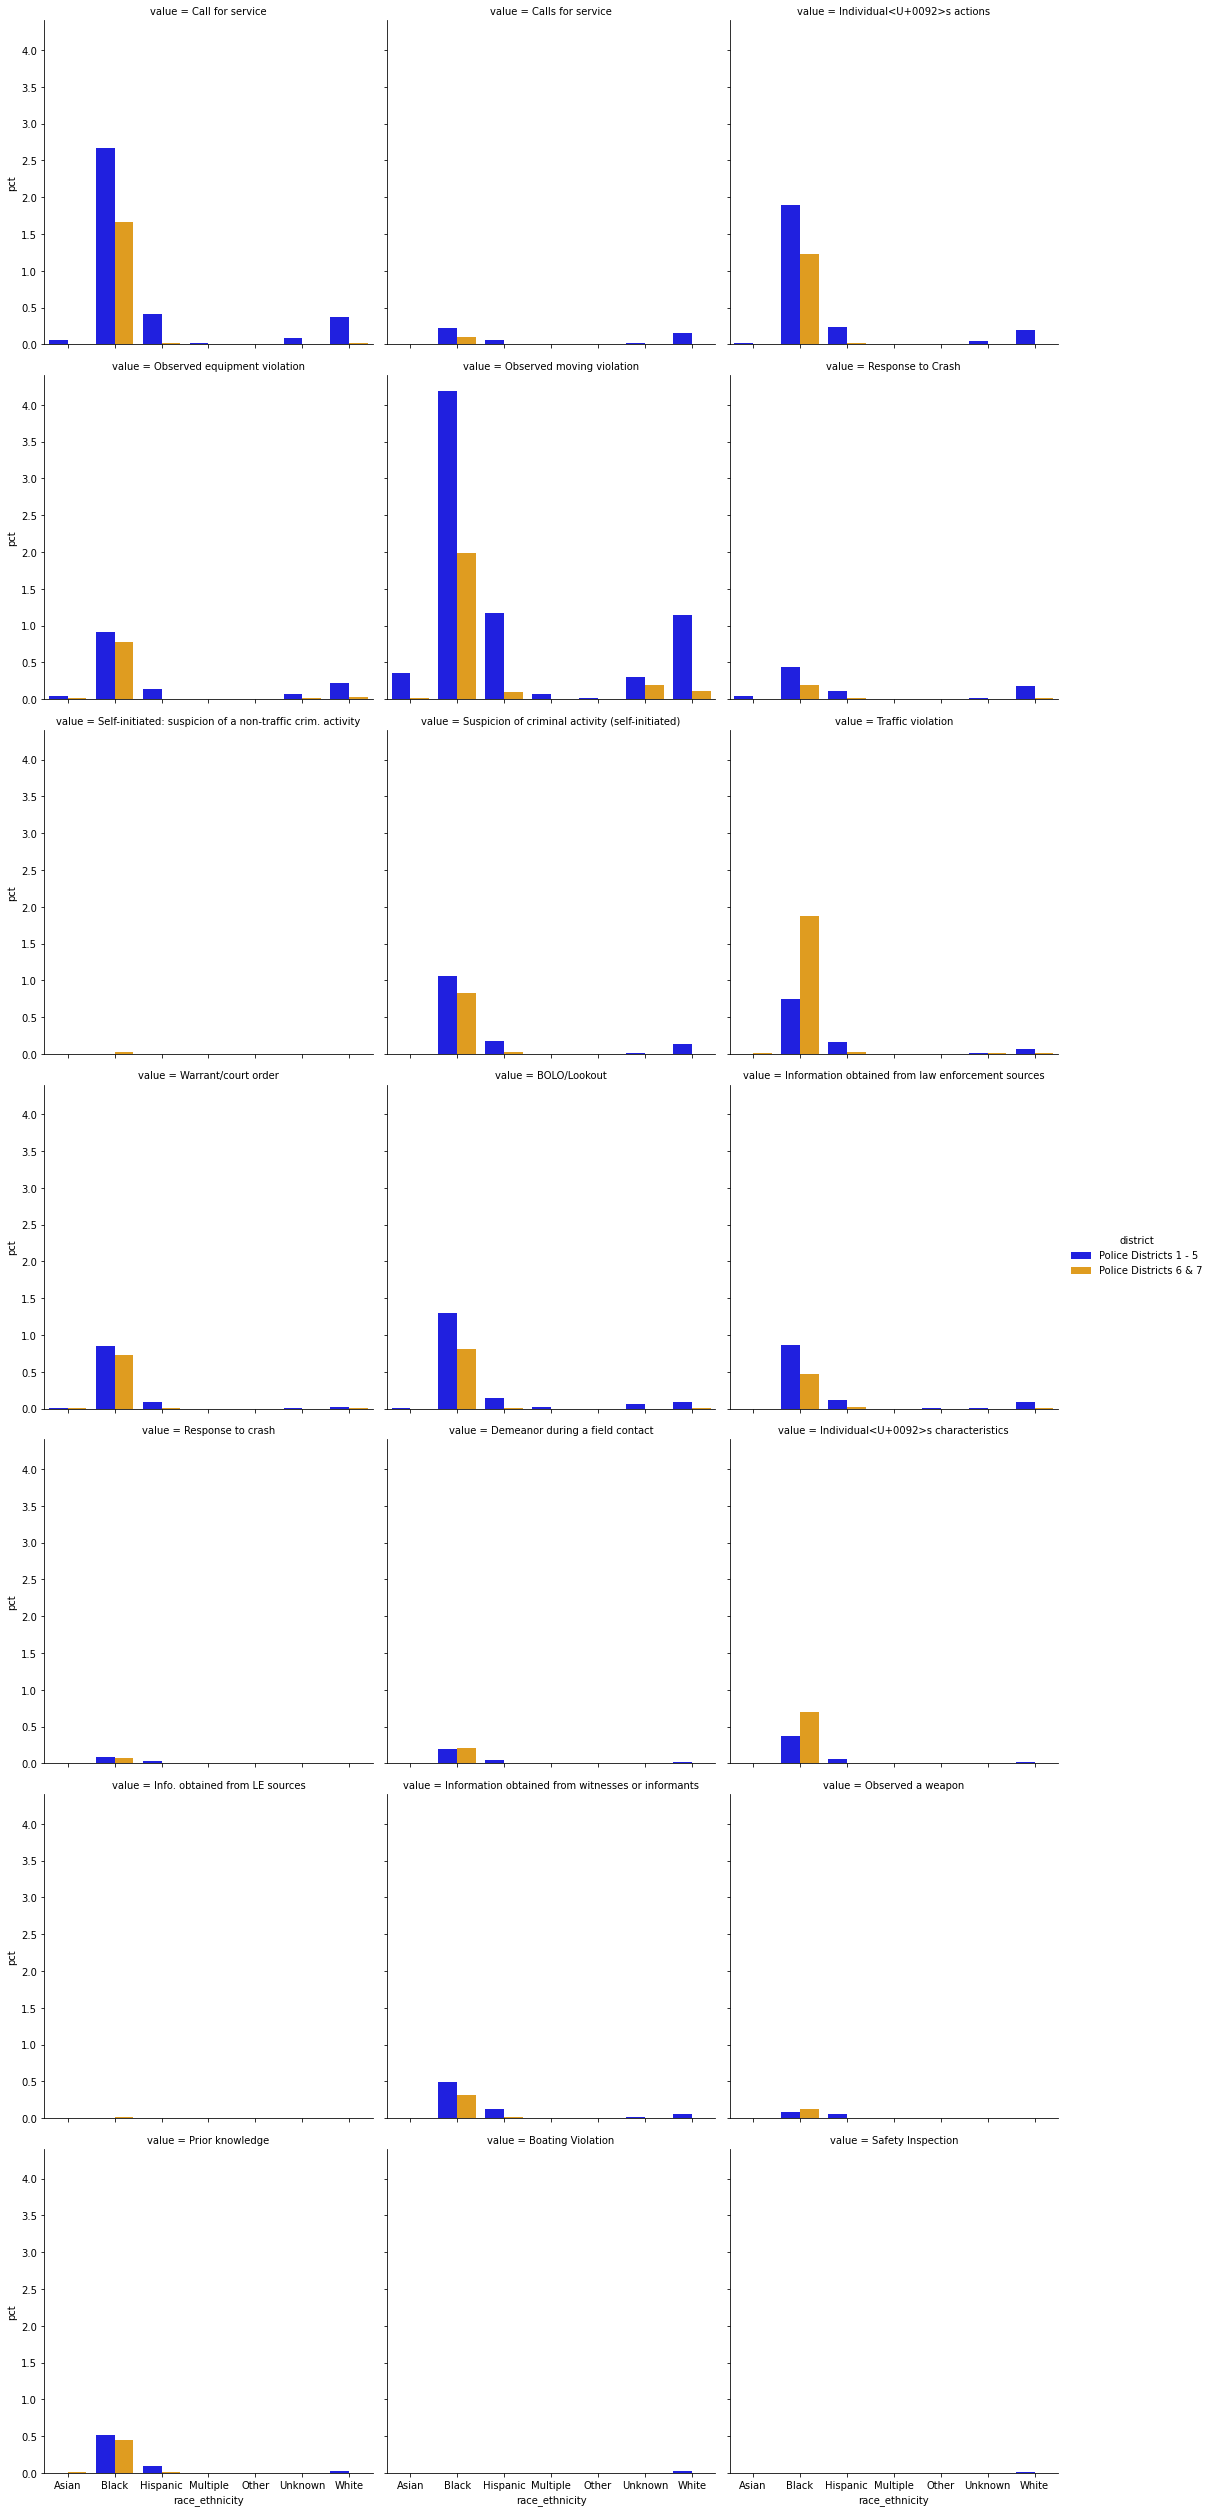

In [91]:
g= sns.catplot(x='race_ethnicity',y='pct',hue='district',col='value',data=grp,kind='bar',col_wrap=3,palette=sns.color_palette(['blue', 'orange']),ci=None)


# Black Males

In [41]:
census = cd.download('acs5', 2018,
                            cd.censusgeo([('state','11'),('public use microdata area','*')]),blk_males)
cols = ['Under 5 years',
'5 to 9 years',
'10 to 14 years',
'15 to 17 years',
'18 and 19 years',
'20 to 24 years',
'25 to 29 years',
'30 to 34 years',
'35 to 44 years',
'45 to 54 years',
'55 to 64 years',
'65 to 74 years',
'75 to 84 years',
'85 years and over']

census.columns = cols
census = census.reset_index()
census['index'] = census['index'].astype(str)
census['puma'] = np.where(census['index'].str.contains('(East)'),1,0)
census =census[['puma']+cols].groupby(['puma']).sum().reset_index()
census_melt = pd.melt(census,id_vars='puma')
census_melt

C:\Users\Noah\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,puma,variable,value
0,0,Under 5 years,4159
1,1,Under 5 years,6715
2,0,5 to 9 years,4418
3,1,5 to 9 years,5509
4,0,10 to 14 years,3685
5,1,10 to 14 years,4824
6,0,15 to 17 years,2442
7,1,15 to 17 years,2778
8,0,18 and 19 years,2209
9,1,18 and 19 years,2078


In [42]:
conditions = [census_melt['variable'].isin(['Under 5 years',
                                '5 to 9 years',
                                '10 to 14 years',
                                '15 to 17 years']),
        census_melt['variable'] == '18 and 19 years',
        census_melt['variable'] == '20 to 24 years',
        census_melt['variable'] == '25 to 29 years',
        census_melt['variable'] == '30 to 34 years',
        census_melt['variable'].isin(['35 to 44 years',
                                '45 to 54 years',
                                '55 to 64 years',
                                '65 to 74 years',
                                '75 to 84 years',
                                '85 years and over'])
       ]

selections =['Under 18\nyears',
'18 and 19\nyears',
'20 to 24\nyears',
'25 to 29\nyears',
'30 to 34\nyears',
'35 and over']


In [43]:
census_melt['age_bucket'] = np.select(conditions,selections)
census_melt = census_melt.groupby(['puma','age_bucket'])['value'].sum().reset_index()
census_melt

,puma,age_bucket,value
0,0,18 and 19\nyears,2209
1,0,20 to 24\nyears,6358
2,0,25 to 29\nyears,7330
3,0,30 to 34\nyears,5973
4,0,35 and over,43581
5,0,Under 18\nyears,14704
6,1,18 and 19\nyears,2078
7,1,20 to 24\nyears,5161
8,1,25 to 29\nyears,5188
9,1,30 to 34\nyears,4515


In [44]:
conditions = [df['age']<=17,
(df['age']>=18)&(df['age']<=19),
(df['age']>=20)&(df['age']<=24),
(df['age']>=25)&(df['age']<=29),
(df['age']>=30)&(df['age']<=34),
(df['age']>=35)]

selections =['Under 18\nyears',
'18 and 19\nyears',
'20 to 24\nyears',
'25 to 29\nyears',
'30 to 34\nyears',
'35 and over']
df['age_bucket'] = np.select(conditions,selections,'missing')
data = df[(df['gender']=='Male')&(df['race_ethnicity']=='Black')&(df['age'].notnull())].groupby(['puma','age_bucket'])['age'].agg(['count']).reset_index()
data

,puma,age_bucket,count
0,0,18 and 19\nyears,514
1,0,20 to 24\nyears,2203
2,0,25 to 29\nyears,2724
3,0,Under 18\nyears,1064
4,1,18 and 19\nyears,444
5,1,20 to 24\nyears,1803
6,1,25 to 29\nyears,2071
7,1,Under 18\nyears,590


In [45]:
census_melt['pct'] = np.round((census_melt['value'] / census_melt['value'].sum())*100,2)
census_melt['var'] = 'black male population'
data['pct'] = np.round((data['count'] / data['count'].sum())*100,2)
data['var'] = 'black male traffic stops'
grp = pd.concat([data,census_melt],axis=0)
grp['district'] = np.where(grp['puma']==0,'Police Districts 1 - 5',"Police Districts 6 & 7")

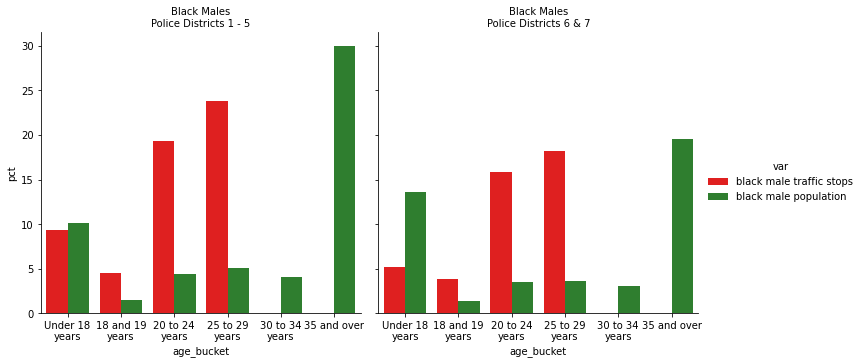

In [46]:
g = sns.catplot(x='age_bucket',y='pct',hue='var',col='district',data=grp,kind='bar',
                palette=sns.color_palette(['red', 'forestgreen']), order=selections)
g.set_titles('Black Males\n{col_name}')

In [117]:
reasons = df[['stop_reason_nonticket','stop_reason_harbor','stop_reason_ticket','observation']].copy()
reasons = pd.concat([reasons['stop_reason_nonticket',],reasons['stop_reason_harbor'],reasons['stop_reason_ticket']],axis=0)
reasons.drop_duplicates(inplace=True)

In [118]:
reasons = reasons.str.split(';',expand=True)
reasons['main']=1
reasons=pd.melt(reasons,id_vars='main')
x = reasons['value'].str.strip().copy()
x.drop_duplicates(inplace=True)

In [120]:
x.values

array([nan, 'Call for service',
       'Information obtained from witnesses or informants',
       'BOLO/Lookout', 'Warrant/court order',
       'Individual<U+0092>s actions', 'Traffic violation',
       'Prior knowledge', 'Response to crash',
       'Demeanor during a field contact',
       'Individual<U+0092>s characteristics',
       'Suspicion of criminal activity (self-initiated)',
       'Information obtained from law enforcement sources',
       'Observed a weapon', 'Safety Inspection', 'Boating Violation',
       'Observed equipment violation', 'Response to Crash',
       'Observed moving violation', 'Calls for service',
       'Self-initiated: suspicion of a non-traffic crim. activity',
       'Info. obtained from LE sources', None], dtype=object)

In [126]:
vol = ['Call for service',
'Information obtained from witnesses or informants',
'BOLO/Lookout', 
'Individual<U+0092>s actions',
'Prior knowledge',
'Demeanor during a field contact',
'Individual<U+0092>s characteristics',
'Suspicion of criminal activity (self-initiated)',
'Information obtained from law enforcement sources',

'Calls for service',
'Self-initiated: suspicion of a non-traffic crim. activity',
'Info. obtained from LE sources']


man = ['Warrant/court order',
       'Observed equipment',
'Observed moving violation',
    'Traffic violation',
        'Response to crash',
            'Observed a weapon',
'Safety Inspection',
'Boating Violation',
    'Response to Crash']
df['police'] = np.where((df['stop_reason_nonticket'].isin(man))|(df['stop_reason_harbor'].isin(man))|(df['stop_reason_ticket'].isin(man)),'mandatory','voluntary')

In [127]:
df['police'].value_counts()

voluntary    10616
mandatory    10226
Name: police, dtype: int64

In [ ]:
df